In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

In [2]:
# This command allows us to zoom and drag plots.
%matplotlib notebook
#%matplotlib inline

In [3]:
protein = pd.read_csv("6126.pdb", delim_whitespace = True, header = None)

In [4]:
protein # [6], [7], [8] represent x,y,z atomic coordinates 

,0,1,2,3,4,5,6,7,8,9,10,11
0,ATOM,1,N,MET,A,3.0,22.210,11.795,16.702,1.0,33.21,N
1,ATOM,2,CA,MET,A,3.0,23.613,11.485,16.448,1.0,25.36,C
2,ATOM,3,C,MET,A,3.0,23.739,10.833,15.087,1.0,24.12,C
3,ATOM,4,O,MET,A,3.0,23.950,9.624,14.970,1.0,28.64,O
4,ATOM,5,CB,MET,A,3.0,24.211,10.545,17.511,1.0,29.59,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1012,ATOM,1013,HD12,LEU,A,64.0,20.403,28.986,-3.600,1.0,13.11,H
1013,ATOM,1014,HD13,LEU,A,64.0,19.767,30.623,-3.403,1.0,16.03,H
1014,ATOM,1015,HD21,LEU,A,64.0,17.920,29.771,-2.026,1.0,16.31,H
1015,ATOM,1016,HD22,LEU,A,64.0,18.481,28.084,-2.077,1.0,14.68,H


In [5]:
# select the alpha carbon backbone only. The fewer the points we select here, the faster our computations are.
CA_backbone = protein[protein[2].isin(['CA'])]
CA_backbone2 = protein[protein[2].isin(['CA',"N"])]
CA_backbone3 = protein[protein[2].isin(['CA',"N","C"])]


In [6]:
# the atoms are in order in the PDB files, so we connect adjacent atoms

def plot_backbone(backbone):

    fig1 = plt.figure(figsize=(10,10))
    ax = fig1.add_subplot(projection='3d')
    ax.scatter(backbone[6].tolist(), backbone[7].tolist(), backbone[8].tolist(), s=30, alpha=0.3, c="b")
    ax.plot3D(backbone[6].tolist(), backbone[7].tolist(), backbone[8].tolist())

    
    return plt.show()

<IPython.core.display.Javascript object>


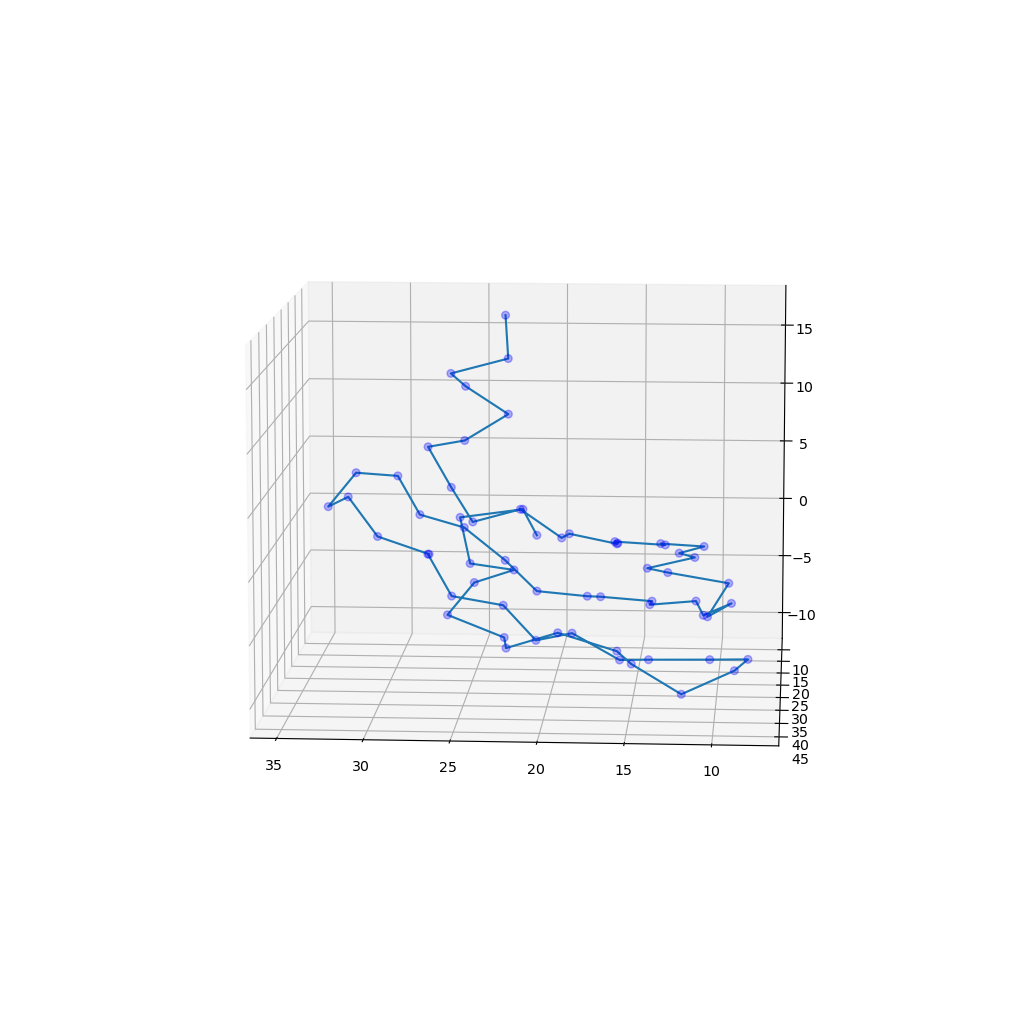

In [7]:
plot_backbone(CA_backbone) #Exploring structure of protein CA backbone
#plot_backbone(CA_backbone2)
#plot_backbone(CA_backbone3)

In [10]:
#Defining euler characteristic curve function
def compute_ecc(data, end_time, starting_point, normal):
    """Computes the Euler characteristic curve along a given direction.

    Direction is given by normal vector. Begin by computing the dot product of the normal vector with the starting
    point. Incrementally increase starting vector to sweep along normal.
    
    A plane is given by the equation a*x+b*y+c*z+d=0 where [a,b,c] is the normal. Thus, we have to calculate d to
    find all points such that a*x+b*y+c*z+d<0.
    
    Subtract the number of edges from the number of points to obtain the Euler characteristic at each timestamp.

    Parameters
    ----------
    data : array-like

        Input point cloud. Points are assumed to be in order.
        
    end_time : scalar
    
        Start time is assumed to be 0. End time is the maximum value that the starting point is multiplied by.
        
    starting_point: array-like
    
        This is the center of the first plane
        
    normal: array-like
    
        The direction along which to sweep the plane

    Returns
    -------
    ecc : list

        The Euler characteristic curve in the given direction.
    """

    ecc = []

    for i in np.linspace(0,end_time,100):
        point  = i*normal+starting_point

        d = -point.dot(normal)
        
        # find all points below the given plane
        sublevel_pts = np.where(data.dot(normal) + d < 0)[0]
        
        # find connected components (connected components will have consecutive vertices)
        consec_vertices = np.split(sublevel_pts, np.where(np.diff(sublevel_pts) != 1)[0]+1)
        # the number of edges is one less than the length of the consecutive vertices
        edges = sum([len(j)-1 for j in consec_vertices])
        points = len(sublevel_pts)
        
        # the above step is coded in a way such that if there are no points, there are -1 edges, which we don't want
        # if there are no points, there should be 0 edges
        if edges < 0:
            edges = 0
        # compute Euler characteristic
        ecc.append(points-edges)
        
    return ecc

In [11]:
# Define a box around the protein's structure by extracting the max and min x, y and z values
#output is coordinates of box´s 8 vertices.
def protein_box(backbone):
 #assuming backbone's [6] is x, [7] is y, and [8] is z
 # get max and min x,y,z. 
 #max(coordinate) + 1 or min(coordinate) -1 ensures that the box´s faces don't touch any protein atoms. 

    max_x = max(backbone[6]) + 1
    max_y = max(backbone[7]) + 1
    max_z = max(backbone[8]) + 1
    
    min_x = min(backbone[6]) - 1
    min_y = min(backbone[7]) - 1
    min_z = min(backbone[8]) - 1
    
#define 8 different vertices of our protein box by getting the 8 possible combinations of max and min x,y,z.
    v1 = [max_x,max_y,max_z]
    v2 = [max_x,max_y,min_z]
    v3 = [max_x,min_y,max_z]
    v4 = [min_x,max_y,max_z]
    v5 = [min_x,min_y,max_z]
    v6 = [min_x,max_y,min_z]
    v7 = [max_x,min_y,min_z]
    v8 = [min_x,min_y,min_z]
    
    
    vertices = [v1,v2,v3,v4,v5,v6,v7,v8]

    return vertices

In [15]:
#Get vertices of backbone's surrouding box
p_box = protein_box(CA_backbone)

#Calculate the box's center by averaging the coordinates of the vertices
box_center = np.array(np.mean(p_box, axis=0))

In [16]:
box_center

array([21.351 , 26.579 ,  3.0625])

<IPython.core.display.Javascript object>


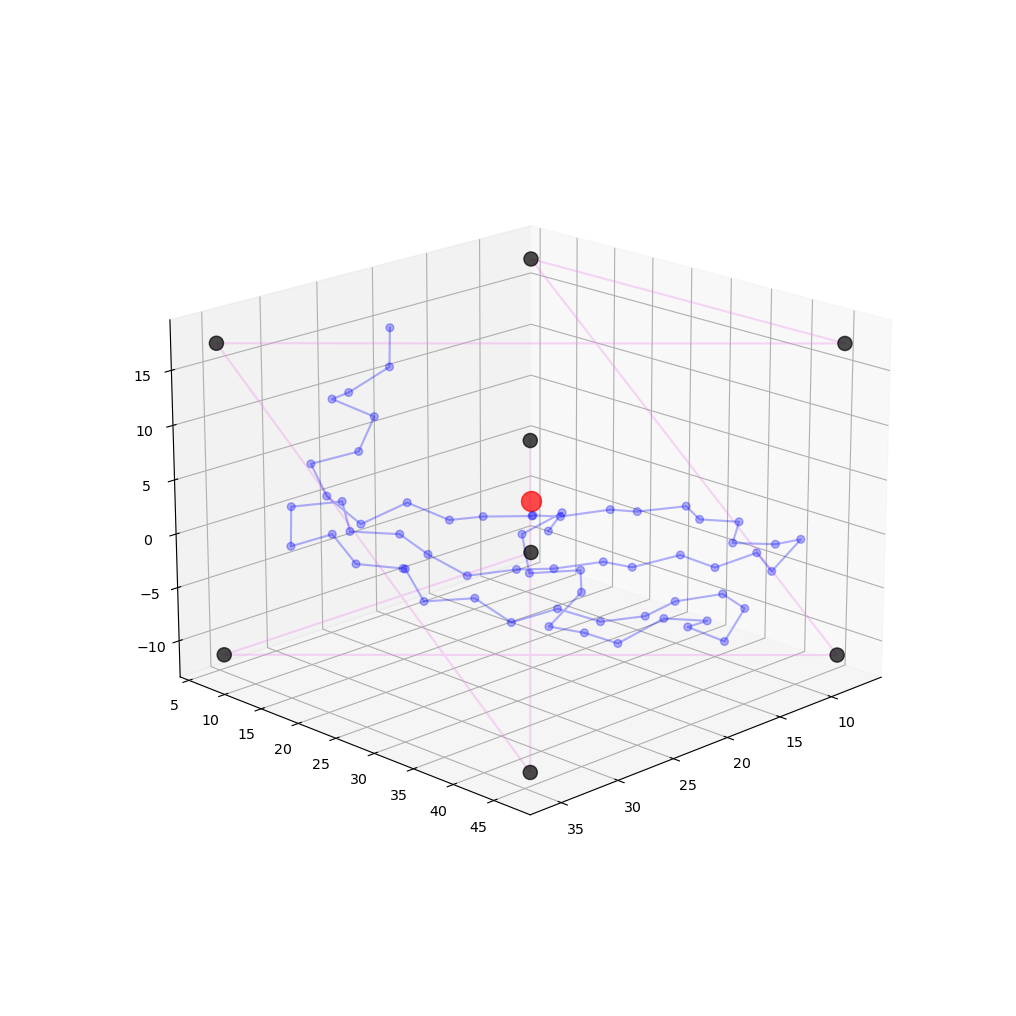

In [28]:
#Visualize protein, box vertices, and box center
df_box = pd.DataFrame(p_box)

%matplotlib notebook
#%matplotlib inline

fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(projection='3d')

#Plot Box Vertices and some edges
ax.scatter(df_box[0].tolist(), df_box[1].tolist(), df_box[2].tolist(),  s=100, alpha=0.7, c="black" )
ax.plot3D(df_box[0].tolist(), df_box[1].tolist(), df_box[2].tolist(), alpha=0.3, c="violet" )

#Plot Box center 
ax.scatter(box_center[0],box_center[1], box_center[2],  s=200, alpha=0.7, c="red" )



#Plot protein atoms inside of box
ax.scatter(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist(), s=30, alpha=0.3, c="b")
ax.plot3D(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist(), alpha=0.3, c="b")



In [30]:
#Calculate the distance between box's center and any of the vertices to get radius of a sphere that encompasses the protein

from scipy.spatial import distance
dst = distance.euclidean(np.array(p_box[0]), box_center)

C:\Users\patri\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
dst

28.403122491198044

In [37]:
#Function for creating a sphere surface around protein using the coordinates of the center, and the radius

def create_sphere(cx,cy,cz, r, resolution=360):
    '''
    create sphere with center (cx, cy, cz) and radius r
    '''
    phi = np.linspace(0, 2*np.pi, 2*resolution)
    theta = np.linspace(0, np.pi, resolution)

    theta, phi = np.meshgrid(theta, phi)

    r_xy = r*np.sin(theta)
    x = cx + np.cos(phi) * r_xy
    y = cy + np.sin(phi) * r_xy
    z = cz + r * np.cos(theta)

    return np.array([x,y,z]) 

In [38]:
prot_sphere = create_sphere(box_center[0],box_center[1],box_center[2],dst)

#Visualize sphere


<IPython.core.display.Javascript object>


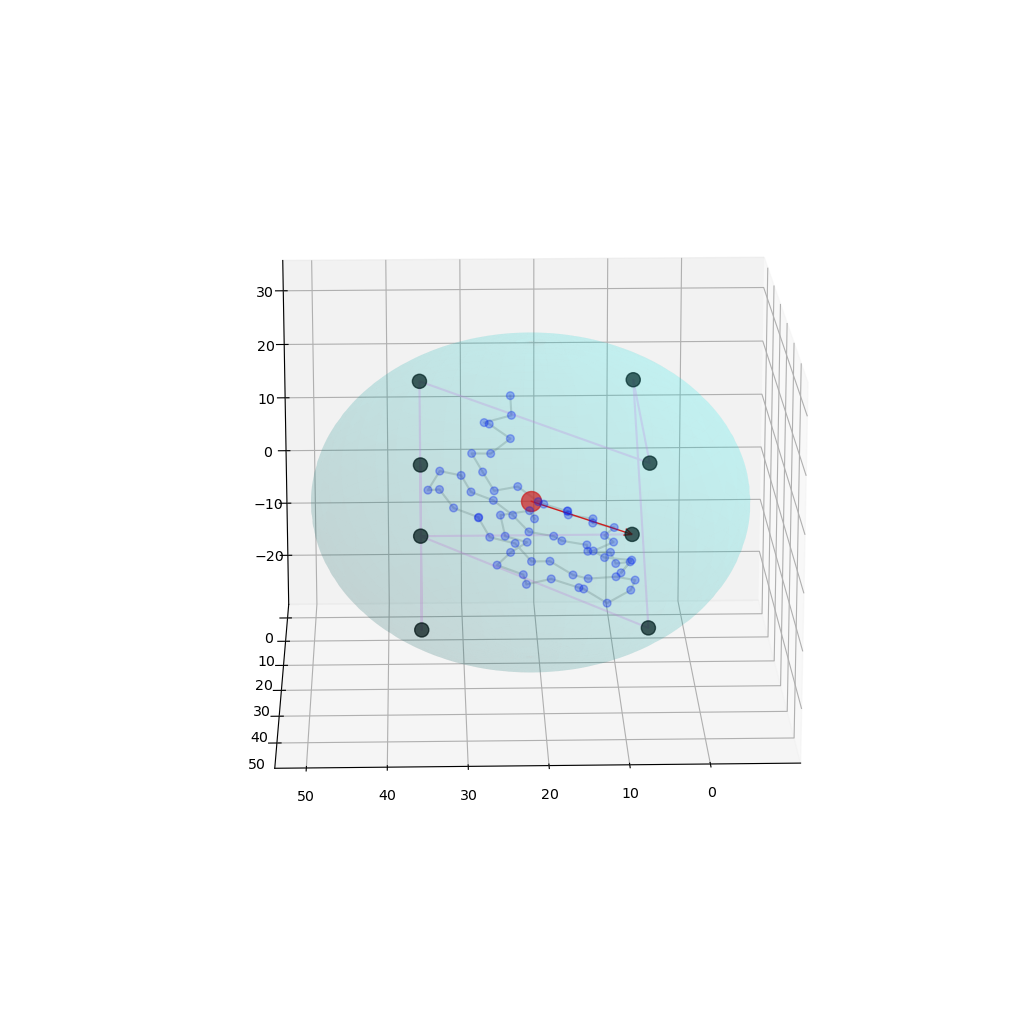

In [63]:
%matplotlib notebook
#%matplotlib inline


fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(projection='3d')

#Plot Box Vertices and some edges connecting them
ax.scatter(df_box[0].tolist(), df_box[1].tolist(), df_box[2].tolist(),  s=100, alpha=0.7, c="black" )
ax.plot3D(df_box[0].tolist(), df_box[1].tolist(), df_box[2].tolist(), alpha=0.3, c="violet" )

#Plot Box center 
ax.scatter(box_center[0],box_center[1], box_center[2],  s=200, alpha=0.7, c="red" )

#Get direction vector from center of the box to any box vertex by subtracting de x,y,z coordinates of the two points

ax.quiver(box_center[0],box_center[1], box_center[2], # <-- starting point of vector
box_center[0]-df_box[0][0],box_center[1]-df_box[1][0], box_center[2]-df_box[2][0], # <-- directions of vector
        color = 'red', alpha = 1, lw = 1, arrow_length_ratio=0.08)


#Plot protein atoms inside of box
ax.scatter(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist(), s=30, alpha=0.3, c="b")
ax.plot3D(CA_backbone[6].tolist(), CA_backbone[7].tolist(),CA_backbone[8].tolist(), alpha=0.3, c="grey" )


#Plot bounding sphere arpund protein box 
ax.plot_surface(prot_sphere[0], prot_sphere[1], prot_sphere[2], color="cyan", alpha=0.1)
plt.show()

In [222]:
#TO DO:
# Figure out how to use sphere to get starting points for ecc

# Meanwhile we can take box vertices as starting points running towards the box's center:

#get directions by subtracting vertices(x,y,z) - center(x,y,z)

directions = pd.DataFrame(box_center - p_box)

#run ecc function on the 8 vertices and directions

output = []


#for i in range(directions.shape[0]):

# we can compute 5 ects as an example
for i in range(5):


    output.append(compute_ecc(np.array(CA_backbone[[6,7,8]]), 10, np.array(df_box.iloc[i,]), np.array(directions.iloc[i,])))

output = np.concatenate(output)




In [231]:
#save output as pkl file

import pickle as pickle

with open('6126.pkl', 'wb') as f:
    pickle.dump(output, f)
